# Airport carbon intensity comparison

In [1]:
import numpy as np
from scipy.optimize import curve_fit, minimize
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [29]:
flights = pd.read_csv("../data/by_route_airline.csv")
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,average_load,co2,gco2_pax_km
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,0.814869,191365.676340,76.944016
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,0.814869,195266.817616,79.051205
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,0.839453,100145.929946,110.904076
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,0.839453,96146.969851,110.549887
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,0.700556,161111.234068,98.852367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,BOO,OSL,11.100400,60.193901,14.365300,67.269203,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,0.646481,3.184374,139.769276
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,0.703706,2.493229,130.487717


In [30]:
flights['RPK'] = flights['passengers'] / flights['flights'] * flights['flown_distance']
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,average_load,co2,gco2_pax_km,RPK
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,0.814869,191365.676340,76.944016,2.515524e+09
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,0.814869,195266.817616,79.051205,2.480272e+09
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,0.839453,100145.929946,110.904076,8.936213e+08
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,0.839453,96146.969851,110.549887,8.619707e+08
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,0.700556,161111.234068,98.852367,1.678008e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,BOO,OSL,11.100400,60.193901,14.365300,67.269203,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,0.646481,3.184374,139.769276,2.278307e+04
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626,2.302834e+04
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626,2.302834e+04
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,0.703706,2.493229,130.487717,1.910700e+04


# Sort by airport

Get list of all airports in dataset

In [31]:
airports_departure = set(flights["departure"].values)
airports_arrival = set(flights["arrival"].values)
airports = np.array(list(airports_departure | airports_arrival))
airports

array(['YKS', 'NBX', 'PGU', ..., 'GEA', 'GAU', 'MCV'],
      shape=(3218,), dtype='<U3')

Total CO2 per airport (=1/2 every flight connection)

In [32]:
departure = np.array(flights['departure'])
arrival = np.array(flights['arrival'])

co2 = np.array([sum(flights[departure == airport]['co2'])/2 +
          sum(flights[arrival == airport]['co2'])/2 for airport in airports])

In [33]:
RPK = np.array([sum(flights[departure == airport]['RPK'])/2 +
          sum(flights[arrival == airport]['RPK'])/2 for airport in airports])

RPK-weighted average CO2 intensity

In [34]:
# from tCO2 to gCO2
mean_intensity = 1000**2*co2/RPK

In [35]:
var_intensity = np.zeros(len(airports))

for i in range(len(airports)):
    d = departure == airports[i]
    a = arrival == airports[i]

    RPK_departure = np.array(flights[d]['RPK'])
    RPK_arrival = np.array(flights[a]['RPK'])

    departure_intensity = np.array(flights[d]['gco2_pax_km'])
    arrival_intensity = np.array(flights[a]['gco2_pax_km'])

    var_intensity[i] = (np.sum(RPK_departure*(departure_intensity - mean_intensity[i])**2) +
                        np.sum(RPK_arrival*(arrival_intensity - mean_intensity[i])**2)) / (np.sum(RPK_departure) + np.sum(RPK_arrival))


Sort airports from low to high CO2 

In [36]:
order = np.argsort(co2)
airports = airports[order]
RPK = RPK[order]
co2 = co2[order]
mean_intensity = mean_intensity[order]
var_intensity = var_intensity[order]

Linear fit to those

In [37]:
def f(x, a, b):
    return a * x + b

popt_mean, _ = curve_fit(f, range(len(airports)), mean_intensity)
popt_var, _ = curve_fit(f, range(len(airports)), np.sqrt(var_intensity))

# Plotting

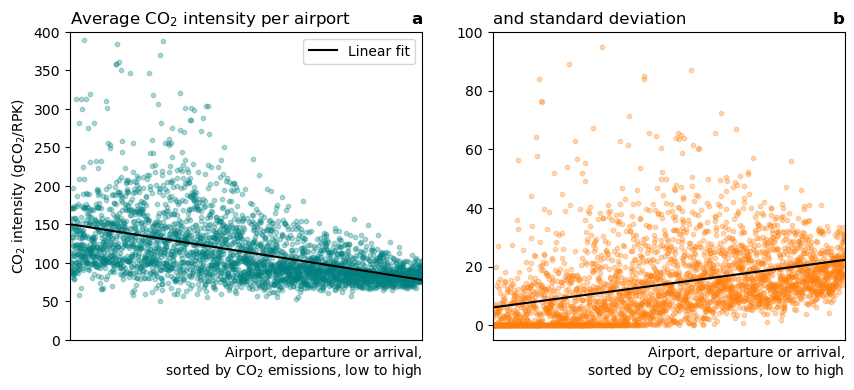

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

ax1.scatter(range(len(airports)), mean_intensity, 10, "teal", alpha=0.3)
ax2.scatter(range(len(airports)), np.sqrt(var_intensity), 10, "C1", alpha=0.3)

i = np.array([0, len(airports)])
mean_fit = f(i, *popt_mean)
var_fit = f(i, *popt_var)

ax1.plot(i, mean_fit, "k", label="Linear fit")
ax2.plot(i, var_fit, "k")

ax1.set_xlim(0, len(airports))
ax1.set_ylim(0, 400)
ax1.set_xticks([])
ax1.set_xlabel("Airport, departure or arrival,\n sorted by CO$_2$ emissions, low to high", loc="right")
ax1.set_ylabel("CO$_2$ intensity (gCO$_2$/RPK)")
ax1.set_title("Average CO$_2$ intensity per airport", loc="left")
ax1.set_title("a", loc="right", fontweight="bold")
ax1.legend(loc="upper right")

ax2.set_ylim(-5, 100)
ax2.set_xlabel("Airport, departure or arrival,\n sorted by CO$_2$ emissions, low to high", loc="right")
# ax2.set_ylabel("CO$_2$ intensity (gCO$_2$/pax/km)")
ax2.set_title("and standard deviation", loc="left")
ax2.set_title("b", loc="right", fontweight="bold")

plt.show()

Fig ?: Carbon intensity per airport, departure or arrival. (a) Mean and (b) standard deviation of carbon intensities across all arriving or departing flights. Both mean and standard deviation are weighted by the respective carbon emissions of that flight. Airports are sorted by their respective total carbon emissions (half of all departures and arrivals), low to high. Linear least-square fits are a applied.

In [42]:
stats.spearmanr(co2, mean_intensity)

SignificanceResult(statistic=np.float64(-0.565626211360215), pvalue=np.float64(1.375805038679333e-271))

In [41]:
stats.spearmanr(co2, var_intensity)

SignificanceResult(statistic=np.float64(0.540529362920826), pvalue=np.float64(1.2557799790350949e-243))

# Order airports by RPK-weighted intensity

In [43]:
order = np.argsort(mean_intensity)[::-1]      # order that sorts by total carbon per airport
co2_r = co2[order]          # sort carbon by that
airports_r = airports[order]      # sort airports by that
mean_intensity_r = mean_intensity[order]  # sort passengers by that

In [44]:
for i in list(range(10))+list(range(len(airports)-10,len(airports))):
    print(f"({i+1}) {airports_r[i]}: {co2_r[i]:.2f} tCO2 per year, {mean_intensity_r[i]:.2f} gCO2/RPK")

(1) PKB: 811.44 tCO2 per year, 649.06 gCO2/RPK
(2) IWD: 1352.64 tCO2 per year, 490.15 gCO2/RPK
(3) BKW: 1923.75 tCO2 per year, 483.62 gCO2/RPK
(4) TUP: 346.97 tCO2 per year, 413.44 gCO2/RPK
(5) AKS: 88.20 tCO2 per year, 407.24 gCO2/RPK
(6) IRA: 77.69 tCO2 per year, 389.15 gCO2/RPK
(7) PGA: 1412.48 tCO2 per year, 388.29 gCO2/RPK
(8) GLH: 433.20 tCO2 per year, 383.82 gCO2/RPK
(9) TVF: 1308.96 tCO2 per year, 370.51 gCO2/RPK
(10) MUA: 464.31 tCO2 per year, 361.23 gCO2/RPK
(3209) NBW: 45.50 tCO2 per year, 58.02 gCO2/RPK
(3210) VXE: 9951.48 tCO2 per year, 57.44 gCO2/RPK
(3211) IKU: 2098.71 tCO2 per year, 56.98 gCO2/RPK
(3212) KUT: 77797.18 tCO2 per year, 56.74 gCO2/RPK
(3213) AAQ: 11866.85 tCO2 per year, 56.40 gCO2/RPK
(3214) RAR: 24942.15 tCO2 per year, 56.19 gCO2/RPK
(3215) GRQ: 3498.38 tCO2 per year, 56.11 gCO2/RPK
(3216) SWF: 15339.13 tCO2 per year, 55.07 gCO2/RPK
(3217) TJU: 23481.62 tCO2 per year, 53.64 gCO2/RPK
(3218) IUE: 1306.28 tCO2 per year, 50.21 gCO2/RPK
